# Disparity calculation using Iterative Lucas-Kanade - Cylinder wake

Reference: https://scikit-image.org/docs/dev/api/skimage.registration.html#optical-flow-ilk

**Setup**

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import pivuq

## Load test data

**Load images**

In [3]:
parent_path = "./data/cylinder_wake//"
image_pair = np.array(
    [
        plt.imread(os.path.join(parent_path + ipath)).astype("float")
        for ipath in ["frameA.tif", "frameB.tif"]
    ]
)

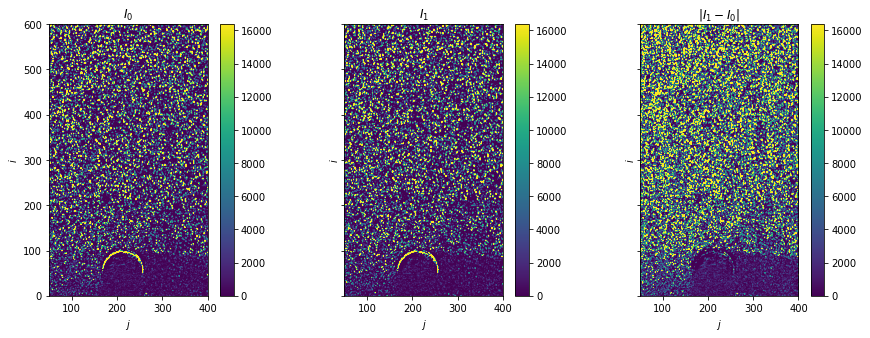

In [4]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 5))

for i, ax in enumerate(axes[:2]):
    im = ax.imshow(image_pair[i], vmax=2**14)
    fig.colorbar(im, ax=ax)
    ax.set(title=f"$I_{i}$")

ax = axes[-1]
im = ax.imshow(np.abs(image_pair[1] - image_pair[0]), vmin=0, vmax=2**14)
fig.colorbar(im, ax=ax)
ax.set(title="$|I_1 - I_0|$")

for ax in axes:
    ax.set(xlim=(50, 400), ylim=(0, 600), xlabel="$j$", ylabel="$i$")

---
## Load reference data

In [5]:
ref = {}

**PIV**

In [6]:
data = np.loadtxt(os.path.join(parent_path + "vectors_PIV.dat"), skiprows=3).T

I, J = 75, 42
ref["PIV"] = {
    "X": np.reshape(data[0], (I, J)) - 1,  # zero-index,
    "Y": np.reshape(data[1], (I, J)) - 1,
    "U": np.stack((np.reshape(data[2], (I, J)), np.reshape(data[3], (I, J)))),
}

**OF**

In [7]:
data = np.load(os.path.join(parent_path + "vectors_OF.npz"))

ref["OF"] = {
    "X": data["X"],  # already zero-indexed
    "Y": data["Y"],
    "U": data["U"],  # u, v
}

---
## Disparity calculation

In [8]:
err = {"PIV": {}, "OF": {}}

**PIV**

In [9]:
%%time
err["PIV"]["X"], err["PIV"]["Y"], err["PIV"]["D"] = pivuq.disparity.ilk(
    image_pair,
    ref["PIV"]["U"],
    window_size=16,
    window="gaussian",
    velocity_upsample_kind="linear",
    warp_direction="center",
    warp_order=1,
    warp_nsteps=5,
)

CPU times: user 6.85 s, sys: 91 ms, total: 6.94 s
Wall time: 6.97 s


**OF**

In [10]:
%%time
err["OF"]["X"], err["OF"]["Y"], err["OF"]["D"] = pivuq.disparity.ilk(
    image_pair,
    ref["OF"]["U"],
    window_size=16,
    window="gaussian",
    velocity_upsample_kind="linear",
    warp_direction="center",
    warp_order=1,
    warp_nsteps=5,
)

CPU times: user 6.71 s, sys: 48.3 ms, total: 6.76 s
Wall time: 6.78 s


---
## Plot

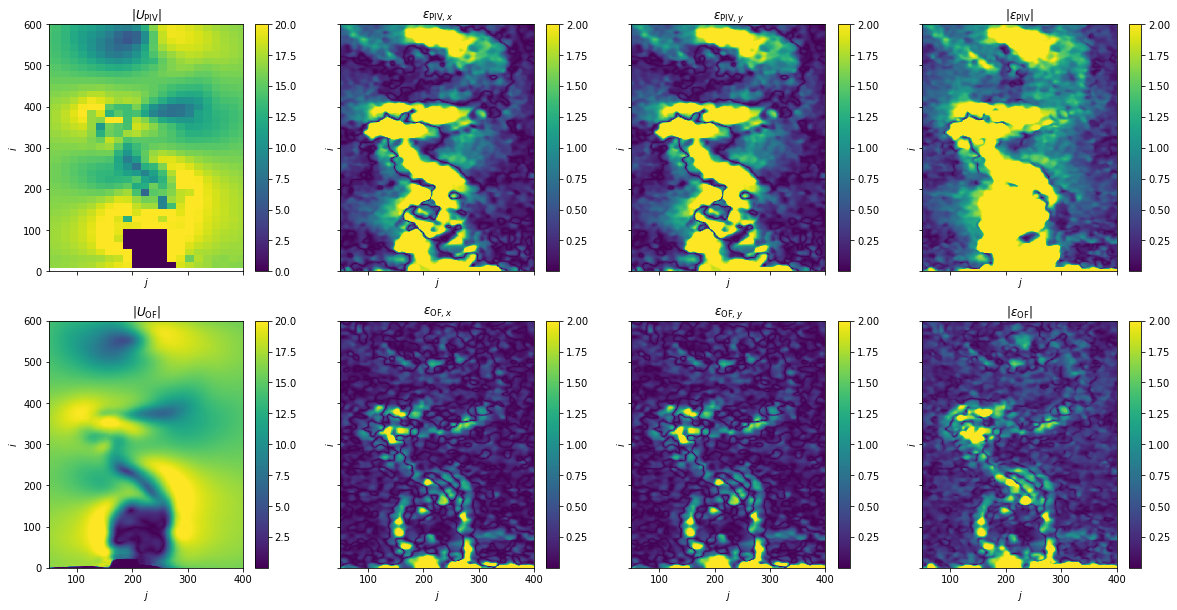

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20, 10))

for i, case in enumerate(["PIV", "OF"]):
    ax = axes[i, 0]
    im = ax.pcolormesh(
        ref[case]["X"], ref[case]["Y"], np.linalg.norm(ref[case]["U"], axis=0), vmax=20
    )
    fig.colorbar(im, ax=ax)
    ax.set(title=rf"$|U_{{\mathrm{{{case}}}}}|$")

    for j, (ax, var) in enumerate(
        zip(
            axes[i, 1:4],
            [
                rf"\epsilon_{{\mathrm{{{case}}},x}}",
                rf"\epsilon_{{\mathrm{{{case}}},y}}",
            ],
        )
    ):
        im = ax.pcolormesh(err[case]["X"], err[case]["Y"], err[case]["D"][i], vmax=2)
        fig.colorbar(im, ax=ax)
        ax.set(title=f"${var}$")

    ax = axes[i, 3]
    im = ax.pcolormesh(
        err[case]["X"], err[case]["Y"], np.linalg.norm(err[case]["D"], axis=0), vmax=2
    )
    fig.colorbar(im, ax=ax)
    ax.set(title=rf"$|\epsilon_{{\mathrm{{{case}}}}}|$")

for ax in axes.ravel():
    ax.set(xlim=(50, 400), ylim=(0, 600), xlabel="$j$", ylabel="$i$")